# Transfer Learning

To predict if an image contains either a cat or a dog using a transfer learning architecture.

References for this tutorial: 
- Article: https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5
- Script: https://colab.research.google.com/drive/1gaIu8snZWKLfvoY2KWP5bvPqFcywl7oy?authuser=1#scrollTo=2ocMy9C52hPY
- Data source: https://www.kaggle.com/c/dogs-vs-cats/data

Concepts:
- What is transfer learning?
- Why do we need it? (rapid progress, improved performance)
- How does it work? 
  - Method 1: Develop model A --> attach to model B.
  - Method 2: Use pretrained model A --> fine-tune layers. 

# Install and Import Modules

Enable GPU:
- Method 1: Edit tab --> Notebook settings --> GPU --> Save.
- Method 2: Runtime tab --> Change runtime type --> GPU --> Save.

In [1]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Check if GPU is present.

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
!nvidia-smi

Tue Jun  8 18:25:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |    222MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load Dataset and Preprocess Data

In [5]:
!pwd

/content


Download and unzip dataset.

In [6]:
%%capture
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip

Copy PetImages folder to train. Rearrange folders inside it. Remove PetImages folder.

In [7]:
!mv PetImages train
!find train/Cat -size  0 -print0 |xargs -0 rm --
!find train/Dog -size  0 -print0 |xargs -0 rm --

Split data into train and test sets.

In [8]:
cats = glob('train/Cat/*.jpg')
dogs = glob('train/Dog/*.jpg')

cats_train, cats_test = train_test_split(cats, test_size=0.30)
dogs_train, dogs_test = train_test_split(dogs, test_size=0.30)

In [9]:
cats_train

['train/Cat/1318.jpg',
 'train/Cat/7379.jpg',
 'train/Cat/2366.jpg',
 'train/Cat/5088.jpg',
 'train/Cat/12315.jpg',
 'train/Cat/2542.jpg',
 'train/Cat/6418.jpg',
 'train/Cat/7179.jpg',
 'train/Cat/10373.jpg',
 'train/Cat/10188.jpg',
 'train/Cat/8593.jpg',
 'train/Cat/8774.jpg',
 'train/Cat/2074.jpg',
 'train/Cat/2589.jpg',
 'train/Cat/8137.jpg',
 'train/Cat/7744.jpg',
 'train/Cat/808.jpg',
 'train/Cat/12087.jpg',
 'train/Cat/7685.jpg',
 'train/Cat/6969.jpg',
 'train/Cat/11700.jpg',
 'train/Cat/12245.jpg',
 'train/Cat/7892.jpg',
 'train/Cat/11439.jpg',
 'train/Cat/4447.jpg',
 'train/Cat/9083.jpg',
 'train/Cat/8760.jpg',
 'train/Cat/11609.jpg',
 'train/Cat/4010.jpg',
 'train/Cat/715.jpg',
 'train/Cat/4624.jpg',
 'train/Cat/8039.jpg',
 'train/Cat/11709.jpg',
 'train/Cat/6157.jpg',
 'train/Cat/9330.jpg',
 'train/Cat/2091.jpg',
 'train/Cat/2050.jpg',
 'train/Cat/4300.jpg',
 'train/Cat/10412.jpg',
 'train/Cat/3774.jpg',
 'train/Cat/6310.jpg',
 'train/Cat/3395.jpg',
 'train/Cat/10601.jpg',
 '

In [10]:
TRAIN_DIR = 'train'
TEST_DIR = 'test'

!mkdir test

!mkdir test/Cat
files = ' '.join(cats_test)
!mv -t test/Cat $files

!mkdir test/Dog
files = ' '.join(dogs_test)
!mv -t test/Dog $files

Display sample images from the train set.

In [11]:
cats = np.random.choice(cats_train, 13)
dogs = np.random.choice(dogs_train, 12)
data = np.concatenate((cats, dogs))
labels = 13 * ['Cat'] + 12 *['Dog']

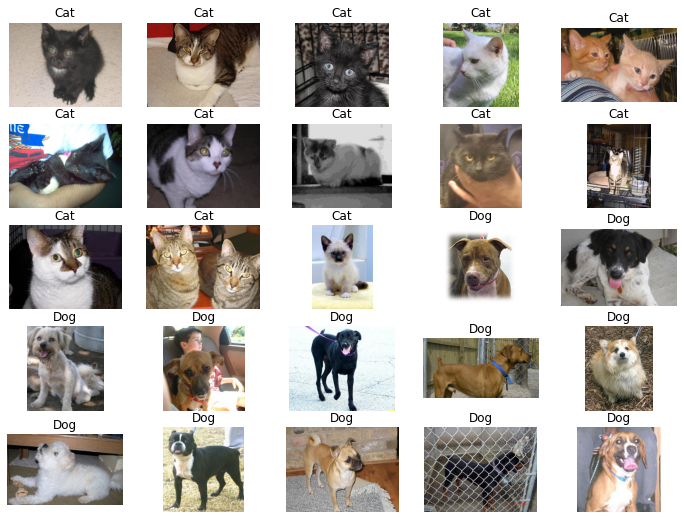

In [12]:
N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))

for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

## Data Augmentation 

In [13]:
WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data generator for train set
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# data generator for test set (it's the same)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# load and preprocess data in batch (train set)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')

# load and preprocess data in batch (test set)
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 17498 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


Display some samples of augmented data from the train set.

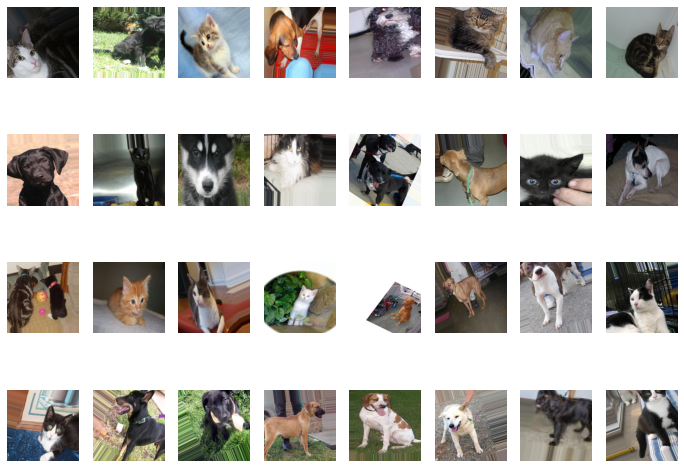

In [14]:
# one batch iteration
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)  # half a size smaller
    plt.axis('off')

# Fine-Tune and Evaluate Transfer Learning Model

In [15]:
CLASSES = 2

# setup pretrained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# freeze pretrained model from retraining
for layer in base_model.layers:
    layer.trainable = False

# setup fine-tune layers
x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)

# complete model
model = Model(inputs=base_model.input, outputs=predictions)

# configure model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


## Transfer Learning

In [16]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'filename.model'

# train and validate with image generators
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,  # repeats current batch training 320 times before next epoch starts
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)

# save the model
model.save(MODEL_FILE)

Epoch 1/5
320/320 [==============================] - 291s 800ms/step - loss: 0.1008 - accuracy: 0.9641 - val_loss: 0.0332 - val_accuracy: 0.9878
Epoch 2/5
320/320 [==============================] - 254s 794ms/step - loss: 0.0539 - accuracy: 0.9800 - val_loss: 0.0613 - val_accuracy: 0.9819
Epoch 3/5
 73/320 [=====>........................] - ETA: 2:42 - loss: 0.0461 - accuracy: 0.9850

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

320/320 [==============================] - 256s 802ms/step - loss: 0.0504 - accuracy: 0.9830 - val_loss: 0.0464 - val_accuracy: 0.9819
Epoch 4/5
320/320 [==============================] - 258s 807ms/step - loss: 0.0517 - accuracy: 0.9822 - val_loss: 0.0367 - val_accuracy: 0.9868
Epoch 5/5
320/320 [==============================] - 257s 803ms/step - loss: 0.0494 - accuracy: 0.9834 - val_loss: 0.0451 - val_accuracy: 0.9849
INFO:tensorflow:Assets written to: filename.model/assets


Plot results.

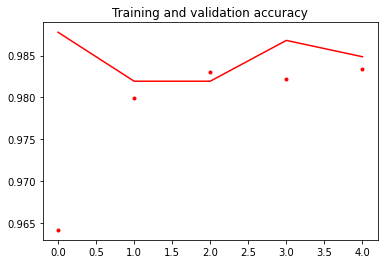

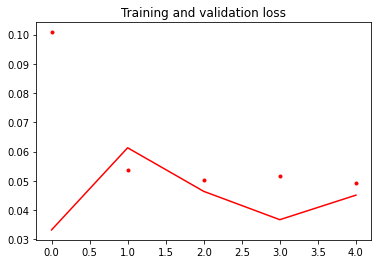

In [18]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r-')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

# Load Saved Model and Make Predictions

In [20]:
def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [22]:
def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("cat", "dog")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [23]:
model = load_model(MODEL_FILE)

array([1.6221395e-05, 9.9998379e-01], dtype=float32)

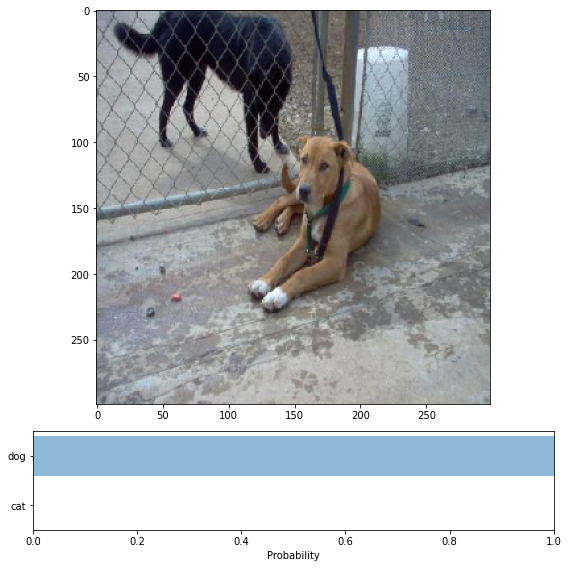

In [24]:
img = image.load_img('test/Dog/110.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds